# 使用量子退火启发式算法求解最大割问题

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_quantum_annealing_inspired_algorithm.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_quantum_annealing_inspired_algorithm.py)&emsp;
[![在Gitee上查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/case_library/quantum_annealing_inspired_algorithm.ipynb)

## 概述

### 最大割问题

组合优化问题是一类在有限的选项集合中找到最优解的数学问题，它有广泛的应用，像投资组合，旅行商问题等。它的求解难度随着问题规模的增加指数增长。因此，目前还不存在高效的经典算法来求解组合优化问题。Max-Cut问题就是其中一种组合优化问题，该问题需要将一个图中的顶点分成两部分，并使得两部分被切割的边最多。如下图：

![max cut](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/Max_Cut.png)


### 量子退火启发式算法

量子启发式算法是一类基于量子力学原理的计算方法衍生或启发的经典力学方法。比较有名的是Ewin tang受HHL启发提出的算法，但目前没有实用场景。为了便于区分，我们把受量子退火或者模拟量子Ising机，称为量子退火启发式算法。研究这类算法的意义在于不断探索经典算法的上界；其次可以对现实问题进行建模，使其能够被量子算法或者量子启发式算法进行求解，并且后续可以用QPU来代替启发式算法进行加速。

量子退火启发式算法主要包括:

- SimCIM(模拟相干伊辛机算法)
- NMFA(含噪平均场退火算法)
- ASB(绝热模拟分叉算法)
- BSB(弹道模拟分叉算法)
- DSB(离散模拟分叉算法)

本篇教程案例，基于量子退火启发式算法求解图分割问题

工作流程：

1. 加载数据，下载 Stanford 的graph 大规模数据集，包含2000个节点
2. 调用mindquantum的qaia模块，选择不同的算法求解器，计算切割值
3. 根据不同算法得到的切割值，绘图，可以直观看到在有限时间内启发式算法得到的近似解逼近理论最优解

**环境准备**
> 需要提前安装[mindquantum>=0.9.11](https://gitee.com/mindspore/mindquantum#%E5%AE%89%E8%A3%85%E6%95%99%E7%A8%8B)

导入常用的Python库和模块


In [1]:
# 设置忽略警告信息，即在程序运行时不输出warning警告信息。
import warnings
warnings.filterwarnings('ignore')

# QAIA量子启发式算法相关求解器
from mindquantum.algorithm.qaia import ASB, BSB, DSB, SimCIM, NMFA

import numpy as np

# 绘图，自定义图例的显示方式，设置字体属性
from matplotlib.legend_handler import HandlerTuple


## 数据准备

下载数据，大规模的无向图数据集来源于[Stanford Professor Yinyu Ye](https://web.stanford.edu/~yyye/)。


In [2]:
# HTTP 网络通信库-requests
import requests

graph_file = 'https://web.stanford.edu/~yyye/yyye/Gset/G22'

# 使用requests库中的get方法发送HTTP请求，将url的响应结果存入变量，再以二进制写入模式打开文件写入本地
response = requests.get(graph_file)
open('G22.txt', 'wb').write(response.content)


# 如果上述-下载图集的代码执行，报错TimeoutError，说明是网络问题
# 可以手动点击网址 https://web.stanford.edu/~yyye/yyye/Gset/G22，下载数据，保存在本地，与该教程同级目录

217828

In [3]:
import time
import pandas as pd
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt


def read_gset(filename, negate=True):
    # 读取图表
    graph = pd.read_csv(filename, sep=' ')
    # 节点的数量
    n_v = int(graph.columns[0])
    # 边的数量
    n_e = int(graph.columns[1])

    # 如果节点和边不匹配，会抛出错误
    assert n_e == graph.shape[0], 'The number of edges is not matched'

    # 将读取的数据转换为一个COO矩阵（Coordinate List Format），并返回一个稀疏矩阵
    G = coo_matrix((np.concatenate([graph.iloc[:, -1], graph.iloc[:, -1]]),
                    (np.concatenate([graph.iloc[:, 0]-1, graph.iloc[:, 1]-1]),
                     np.concatenate([graph.iloc[:, 1]-1, graph.iloc[:, 0]-1]))), shape=(n_v, n_v))
    if negate:
        G = -G

    return G

G = read_gset("./G22.txt")

## 运行量子启发式求解器

读取数据集，转换成对应的graph矩阵后，使用QAIA量子启发式算法进行求解MAX-CUT问题
mindquantum集成了强大、丰富的[启发式算法QAIA武器库](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/algorithm/mindquantum.algorithm.qaia.html#module-mindquantum.algorithm.qaia)

- mindquantum.algorithm.qaia.QAIA    量子退火启发式算法基类。
- mindquantum.algorithm.qaia.CAC    混沌振幅控制算法。
- mindquantum.algorithm.qaia.CFC    混沌振幅反馈算法
- mindquantum.algorithm.qaia.LQA    局域量子退火算法。
- mindquantum.algorithm.qaia.NMFA    含噪平均场退火算法。
- mindquantum.algorithm.qaia.ASB    绝热模拟分叉算法。
- mindquantum.algorithm.qaia.BSB    弹道模拟分叉算法。
- mindquantum.algorithm.qaia.DSB    离散模拟分叉算法。
- mindquantum.algorithm.qaia.SFC    离散振幅反馈算法。
- mindquantum.algorithm.qaia.SimCIM  模拟相干伊辛机算法。

> 下面使用"NMFA/含噪平均场退火算法", "SimCIM/模拟相干伊辛机算法", "ASB/绝热模拟分叉算法", "BSB弹道模拟分叉算法", "DSB离散模拟分叉算法"。
分别求解MAX-CUT问题，并设置采样次数和迭代次数，得到近似解，运行时间。
最后比较五种算法得到的近似解和理论最终解，体现出QAIA启发式算法的优势。



In [4]:
# 设置采样次数，迭代步数，切割值
sample_size = 100

n_iter_list = [10, 25, 50, 75, 100, 250, 500, 750, 1000]

cut_value_list = []

In [5]:
# 开始时间，统计运行时间
start_time = time.time()


for n_iter in n_iter_list:
    # 使用NMFA算法，设置耦合矩阵、样本次数、迭代次数
    s = NMFA(G, batch_size=sample_size, n_iter=n_iter)
    # 动力学演化
    s.update()
    # 计算切割值
    cut_value = s.calc_cut()
    cut_value_list.append(cut_value)

ntime = time.time()
print(f"NMFA dynamical evolution complete, \trun time {ntime-start_time}")


for n_iter in n_iter_list:
    # 使用SimCIM算法，设置耦合矩阵、样本次数、迭代次数、迭代步长、噪声标准差
    s = SimCIM(G, batch_size=sample_size, n_iter=n_iter, dt=0.5, sigma=1)
    s.update()
    cut_value = s.calc_cut()
    cut_value_list.append(cut_value)

stime = time.time()
print(f"SimCIM dynamical evolution complete, \trun time {stime-ntime}")


for n_iter in n_iter_list:
    # 使用ASB算法，设置耦合矩阵、样本次数、迭代次数
    s = ASB(G, batch_size=sample_size, n_iter=n_iter)
    s.update()
    cut_value = s.calc_cut()
    cut_value_list.append(cut_value)

atime = time.time()
print(f"ASB dynamical evolution complete, \trun time {atime-stime}")


for n_iter in n_iter_list:
    # 使用BSB算法，设置耦合矩阵、样本次数、迭代次数
    s = BSB(G, batch_size=sample_size, n_iter=n_iter)
    s.update()
    cut_value = s.calc_cut()
    cut_value_list.append(cut_value)

btime = time.time()
print(f"BSB dynamical evolution complete, \trun time {btime-atime}")


for n_iter in n_iter_list:
    # 使用DSB算法，设置耦合矩阵、样本次数、迭代次数
    s = DSB(G, batch_size=sample_size, n_iter=n_iter)
    s.update()
    cut_value = s.calc_cut()
    cut_value_list.append(cut_value)

dtime = time.time()
print(f"DSB dynamical evolution complete, \trun time {dtime-btime}")
print(f'use time {dtime-start_time}')

NMFA dynamical evolution complete, 	run time 27.952094316482544
SimCIM dynamical evolution complete, 	run time 20.83353018760681
ASB dynamical evolution complete, 	run time 29.15273404121399
BSB dynamical evolution complete, 	run time 11.221607446670532
DSB dynamical evolution complete, 	run time 15.010071277618408
use time 104.17003726959229


In [6]:
# 转换成numpy array格式的矩阵
cut_value_list = np.array(cut_value_list)

## 验证结果

使用不同的启发式算法，得到切割值近似解后，再对比理论最优解，绘图比较。
可以直观发现面对大规模图分割问题，QAIA算法在10s级时间内，**近似解即可逼近到最优解，优势明显**。

In [7]:
# 设置标签、标识、颜色
label = ["NMFA", "SimCIM", "aSB", "bSB", "dSB", "BLS"]
marker = ["^", "o", "*", "s", "P", "d"]
color = ["olivedrab", "darkorange", "grey", "dodgerblue", "red"]

### 1.绘制折线图

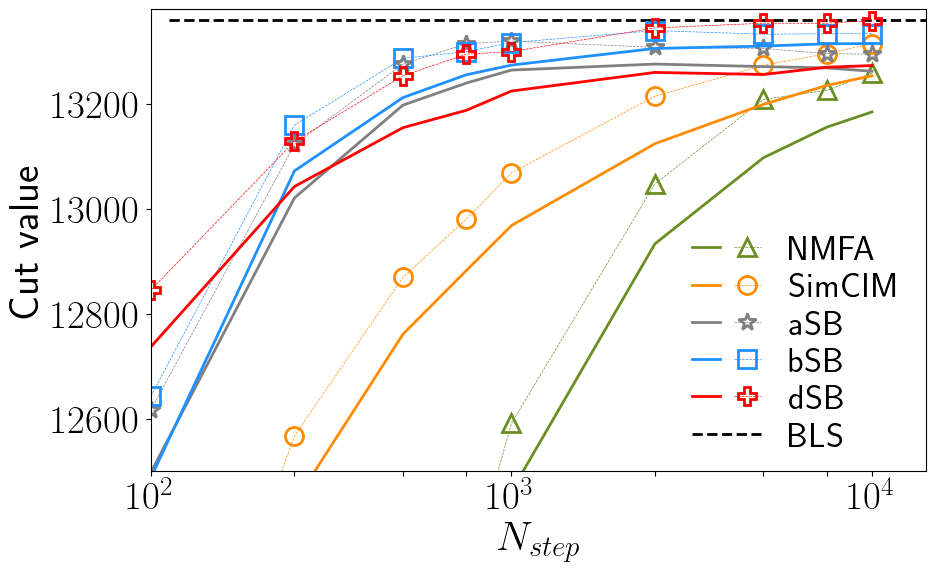

In [8]:
# Cut value curves，设置figure画布 尺寸
legend_list = []
plt.figure(figsize=(10, 6))
mean_list = []
max_list = []

# 查表可知，G22.txt对应的节点图，MAXCUT的理论最优解是13359
# 设置最优解的折线，x\y轴
(best,) = plt.plot([1.05, 3.15], [13359, 13359], "--k", linewidth=2)

# 遍历，将五种算法得到的切割值近似解，绘图
for i, l in enumerate(label[:-1]):
    tmp_mean_list = []
    tmp_max_list = []
    for j in range(len(n_iter_list)):
        tmp = cut_value_list[i * 9 + j]
        mean_val = np.mean(tmp)
        max_val = np.max(tmp)
        tmp_mean_list.append(mean_val)
        tmp_max_list.append(max_val)
    (mean_axis,) = plt.plot(
        np.log10(n_iter_list), tmp_mean_list, color=color[i], linewidth=2
    )
    (max_axis,) = plt.plot(
        np.log10(n_iter_list),
        tmp_max_list,
        "--o",
        marker=marker[i],
        color=color[i],
        markersize=13,
        linewidth=0.5,
        mfc="none",
        mew=2,
    )
    legend_list.append((mean_axis, max_axis))


# 根据散点拟合成折线
legend_list.append(best)
plt.xlim([1.05, 3.15])
plt.ylim(bottom=12500, top=13380)
plt.xticks(
    np.log10(n_iter_list), ["$10^2$", "", "", "", "$10^3$", "", "", "", "$10^4$"]
)
plt.tick_params(labelsize=28)
plt.xlabel(r"$N_{step}$", fontsize=30)
plt.ylabel(r"Cut value", fontsize=30)
plt.legend(
    legend_list,
    label,
    numpoints=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=25,
    frameon=False,
    labelspacing=0.18,
    loc=(0.68, 0.01),
)

### 2.绘制直方图

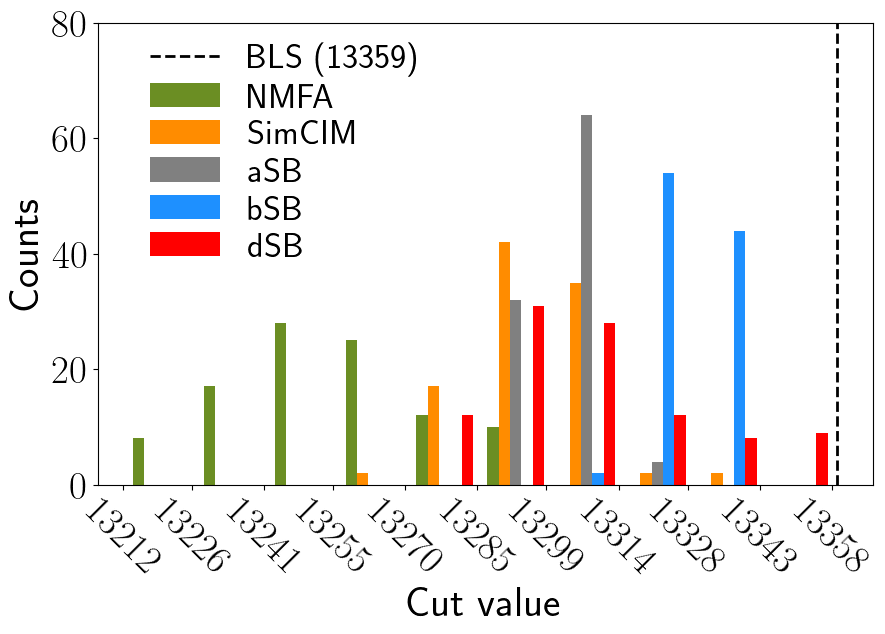

In [9]:

# Histogram，创建画布，设置区间、颜色、标签、中心对齐
plt.figure(figsize=(10, 6))
res = plt.hist(
    cut_value_list[np.arange(8, 46, 9)].T,
    bins=10,
    color=color,
    label=label,
    align="mid",
)

# 绘直方图
plt.plot([13359, 13359], [0, 1050], "--k", linewidth=2, label="BLS (13359)")
plt.ylim([0, 80])
plt.legend(fontsize=25, frameon=False, loc=(0.05, 0.45), labelspacing=0.18)
plt.xlabel("Cut value", fontsize=30)
plt.ylabel("Counts", fontsize=30)
plt.xticks(
    res[1].astype(np.int) - 1,
    [
        "$13212$",
        "$13226$",
        "$13241$",
        "$13255$",
        "$13270$",
        "$13285$",
        "$13299$",
        "$13314$",
        "$13328$",
        "$13343$",
        "$13358$",
    ],
    rotation=-45,
)
plt.tick_params(labelsize=28)

In [10]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')


Software,Version
mindquantum,0.9.11
scipy,1.8.1
numpy,1.21.5
System,Info
Python,3.9.12
OS,Linux x86_64
Memory,1623.2 GB
CPU Max Thread,192
Date,Tue Mar 5 12:29:37 2024


## 参考文献：

- [mindquantum.algorithm.qaia API](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.9/algorithm/mindquantum.algorithm.qaia.html#module-mindquantum.algorithm.qaia)
- A. Lucas Ising formulations of many NP problems. Front. Physics 2, 5 (2014).
- H. Goto,K. Tatsumura, A. R. Dixon, Combinatorial optimization by simulating adiabatic bifurcations in nonlinear
- Hamiltonian systems.Sci. Adv. 5, eaav2372 (2019).